In [246]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# random seed
np.random.seed(4231)

%matplotlib inline

## Data Description

<table>
<thead>
    <tr>
        <td>
            Variable Name
        </td>
        <td>
            Description
        </td>
        <td>
            Type
        </td>
    </tr>
</thead>
<tbody>
    <tr>
        <td>
            SeriousDlqin2yrs
        </td>
        <td>
            Person experienced 90 days past due delinquency or worse 
        </td>
        <td>
            Y/N
        </td>
    </tr>
    <tr>
        <td>
            RevolvingUtilizationOfUnsecuredLines
        </td>
        <td>
            Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits 
        </td>
        <td>
            percentage
        </td>
    </tr>
    <tr>
        <td>
            age
        </td>
        <td>
            Age of borrower in years 
        </td>
        <td>
            int
        </td>
    </tr>
    <tr>
        <td>
            NumberOfTime30-59DaysPastDueNotWorse
        </td>
        <td>
            Number of times borrower has been 30-59 days past due but no worse in the last 2 years. 
        </td>
        <td>
            int
        </td>
    </tr>
    <tr>
        <td>
            DebtRatio
        </td>
        <td>
            Monthly debt payments, alimony,living costs divided by monthy gross income 
        </td>
        <td>
            percentage
        </td>
    </tr>
    <tr>
        <td>
            MonthlyIncome
        </td>
        <td>
            Monthly income 
        </td>
        <td>
            int
        </td>
    </tr>
    <tr>
        <td>
            NumberOfOpenCreditLinesAndLoans
        </td>
        <td>
            Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) 
        </td>
        <td>
            int
        </td>
    </tr>
    <tr>
        <td>
            NumberOfTimes90DaysLate
        </td>
        <td>
            Number of times borrower has been 90 days or more past due.
        </td>
        <td>
            int
        </td>
    </tr>
    <tr>
        <td>
            NumberRealEstateLoansOrLines
        </td>
        <td>
             Number of mortgage and real estate loans including home equity lines of credit
        </td>
        <td>
            int
        </td>
    </tr>
    <tr>
        <td>
            NumberOfTime60-89DaysPastDueNotWorse
        </td>
        <td>
            Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
        </td>
        <td>
            int
        </td>
    </tr>
    <tr>
        <td>
            NumberOfDependents
        </td>
        <td>
            Number of dependents in family excluding themselves (spouse, children etc.)
        </td>
        <td>
            int
        </td>
    </tr>
</tbody>
</table>

## Helper Functions

* Need a function that would shuffle a data frame.
* Need a function that would perform a given transformation on a given feature for a dataframe.
* Function that return suitable features for One Hot Encoding.
* Function that would find cardinality of a given feature.
* Function that would convert predictions ( probability of YES ) to rank.
* Function to save a submission

### Future Goals

- Perform log transformations on features that would are skewed. **[ done ]**
- Encode some of the variables as One Hot Encoded Features to see if they capture anything different.
- Tune the base XGBoost model to see if we can take leverage from it or not. **[ done ]**
- Train different models and combine their results.

In [175]:
def get_ranks(y_preds):
    """
    Returns normalized ranks
    """
    if y_preds is None:
        raise ValueError('Predictions are required')
    
    if type(y_preds) is not np.ndarray:
        y_preds = np.array(y_preds)
    
    ranks = [0] * len(y_preds)
    
    for i, x in enumerate(sorted(range(len(y_preds)), key=lambda y: y_preds[y])):
        ranks[x] = i + 1 # here i represent the rank and x represent the sorted value
    
    ranks = np.array(ranks)
    max_rank = ranks.max() * 1.
    
    return ranks / max_rank

def shuffle_df(df):
    """
    Shuffle a data frame
    
    Args:
        df: DataFrame
    
    Return:
        Shuffled Dataframe
    """
    df = df.iloc[np.random.permutation(len(df))]
    return df

def transform_feature(df, feature_name, transform_func):
    """
    Perform a given transformation on a given feature
    
    Args:
        df: Dataframe
        feature_name: Name of the column/feature
        transform_func: Transformation Function
        
    Return:
        Transformed Feature
    """
    
    df[feature_name] = df[feature_name].map(transform_func)
    return df[feature_name]

def get_cardinality(df, feature_name):
    """
    Gets cardinality of a feature
    
    Args:
        df: Dataframe
        feature_name: Name of the column
    
    Return:
        Cardinality of the feature
    """
    
    return len(df[feature_name].value_counts().index)

def features_for_ohe(df, cardinality_threshold=4):
    """
    Returns features that are suitable for one hot encoding based on the cardinality
        
    Args:
        df: Dataframe
        cardinality_threshold: int
        
    Return:
        List of features that are suitable for one hot encoding
    """
    
    columns = df.columns
    suitable_features = [col for col in columns if get_cardinality(df, col) > cardinality_threshold]
    
    return suitable_features

def get_ohe(df, cols):
    """
    Returns one hot encoding representation of the data
    
    Args:
        df: Dataframe
        cols: List of the cols that need that needs to be encoded
    
    Return:
        One Hot Encoded representation of the dataframe
    """
        
    return pd.get_dummies(df, columns=cols, sparse=True)

def save_submission(submission_df, ranks, filename):
    """
    Save a submission csv file in ../submissions folder
    
    Args:
        submission_df: Sample submission dataframe
        ranks: Ranks/Probability of Yes originated from our model
        filename: Filename of the csv    
    """
    
    submission_df['Probability'] = ranks
    submission_df.to_csv('../submissions/%s'%(filename), index=False)

In [12]:
len(train.NumberOfDependents.value_counts().index)

13

In [191]:
# load training and test data
train = pd.read_csv('../data/cs-training.csv')
test = pd.read_csv('../data/cs-test.csv')

In [5]:
# shape of both the datasets
print 'Shape of training set %s and test set %s ' %(train.shape, test.shape)

Shape of training set (150000, 12) and test set (101503, 12) 


In [6]:
print 'Features in training set %s \n Features in test set %s ' %(train.columns, test.columns)

Features in training set Index([u'Unnamed: 0', u'SeriousDlqin2yrs',
       u'RevolvingUtilizationOfUnsecuredLines', u'age',
       u'NumberOfTime30-59DaysPastDueNotWorse', u'DebtRatio', u'MonthlyIncome',
       u'NumberOfOpenCreditLinesAndLoans', u'NumberOfTimes90DaysLate',
       u'NumberRealEstateLoansOrLines',
       u'NumberOfTime60-89DaysPastDueNotWorse', u'NumberOfDependents'],
      dtype='object') 
 Features in test set Index([u'Unnamed: 0', u'SeriousDlqin2yrs',
       u'RevolvingUtilizationOfUnsecuredLines', u'age',
       u'NumberOfTime30-59DaysPastDueNotWorse', u'DebtRatio', u'MonthlyIncome',
       u'NumberOfOpenCreditLinesAndLoans', u'NumberOfTimes90DaysLate',
       u'NumberRealEstateLoansOrLines',
       u'NumberOfTime60-89DaysPastDueNotWorse', u'NumberOfDependents'],
      dtype='object') 


In [192]:
# concatenate train and test set
data = pd.concat([train, test])

## Plot Histograms to see variations

** Summary **
* Many of the features require transformation.
* Monthly Income and NumberOfDependents variables have missing values.

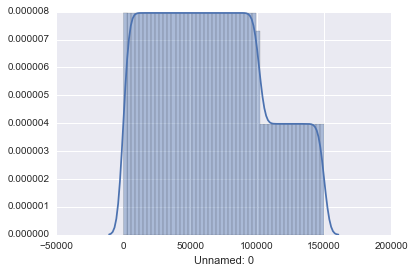

In [47]:
sns.distplot(data['Unnamed: 0']);

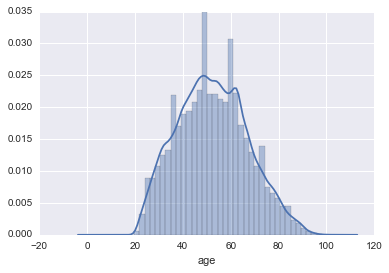

In [31]:
sns.distplot(data['age']);

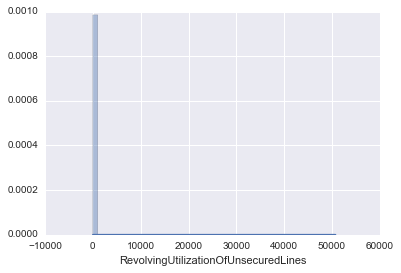

In [32]:
sns.distplot(data['RevolvingUtilizationOfUnsecuredLines']);

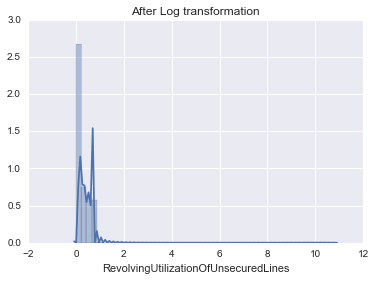

In [41]:
sns.distplot(data['RevolvingUtilizationOfUnsecuredLines'].map(np.log1p))
plt.title('After Log transformation');

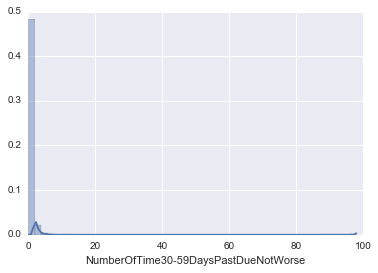

In [33]:
sns.distplot(data['NumberOfTime30-59DaysPastDueNotWorse']);

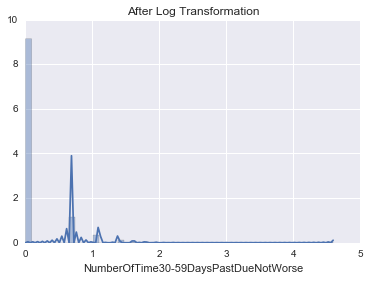

In [42]:
sns.distplot(data['NumberOfTime30-59DaysPastDueNotWorse'].map(np.log1p))
plt.title('After Log Transformation');

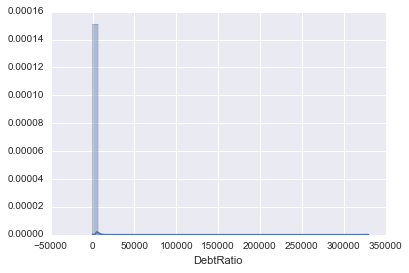

In [34]:
sns.distplot(data['DebtRatio']);

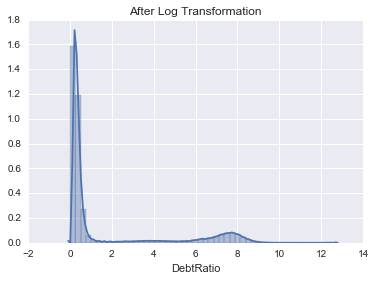

In [43]:
sns.distplot(data['DebtRatio'].map(np.log1p))
plt.title('After Log Transformation');

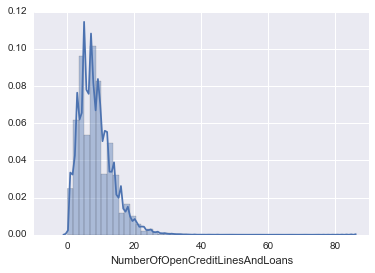

In [35]:
sns.distplot(data['NumberOfOpenCreditLinesAndLoans']);

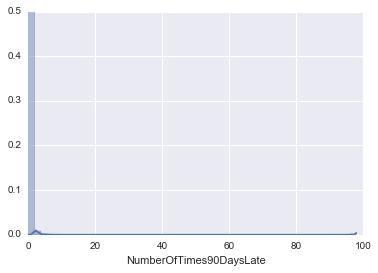

In [36]:
sns.distplot(data['NumberOfTimes90DaysLate']);

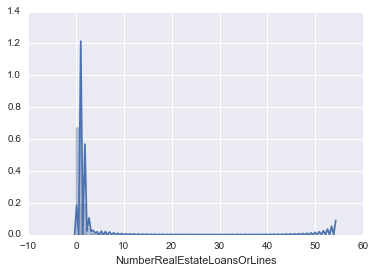

In [37]:
sns.distplot(data['NumberRealEstateLoansOrLines']);

## Which of the features have missing values ?

In [9]:
train.isnull().any()

Unnamed: 0                              False
SeriousDlqin2yrs                        False
RevolvingUtilizationOfUnsecuredLines    False
age                                     False
NumberOfTime30-59DaysPastDueNotWorse    False
DebtRatio                               False
MonthlyIncome                            True
NumberOfOpenCreditLinesAndLoans         False
NumberOfTimes90DaysLate                 False
NumberRealEstateLoansOrLines            False
NumberOfTime60-89DaysPastDueNotWorse    False
NumberOfDependents                       True
dtype: bool

## Imputation Strategies

* Impute missing values with mean of the values
* Impute missing values with median of the values
* Impute missing values with mode of the values
* Impute missing values based on the target variable

** This will essentially create 4 different representation of the dataset **

In [334]:
class Imputation(object):
    
    def __init__(self, df, strategy):
        """
        Args:
            df: Dataframe ( concatenated train and test dataframes )
        """
        self.strategy = strategy
        self.df = df.copy()
    
    def get_df(self):
        """
        Returns the data frame
        """
        return self.df
    
    def features_with_missing_values(self):
        """
        Returns features with missing values
        """
        
        # omit the target variable
        columns = self.df.columns
        missing_val_features = list(columns[self.df.isnull().any()].values)
        self.missing_val_features = np.array(filter(lambda x: x != 'SeriousDlqin2yrs', missing_val_features))
        return self.missing_val_features
        
    
    def fill_missing_values(self):
        """
        Fill the missing values
        """
        
        strategy = self.strategy
        missing_val_features = self.missing_val_features
        
        for feat in missing_val_features:
            if strategy == 'mean':
                self.df[feat] = self.df[feat].fillna(self.df[feat].mean())
            elif strategy == 'median':
                self.df[feat] = self.df[feat].fillna(self.df[feat].median())
            elif strategy == 'mode':
                self.df[feat] = self.df[feat].fillna(self.df[feat].mode()[0])
    

## Datasets

** Objective is to create different instances of the dataset. Make sure whatever we do to the training examples must be applied to test examples as well. **

* Create instances based on different imputation strategies
* Create instances based on different features selected
* Create instances based on how we encode variables ( One Hot Encoding or Label Encoding etc. )
* Create instances based on example subset of rows chosen based on some criteria ( example omit outliers. )

In [335]:
class Datasets(object):
    
    def __init__(self, df):
        self.df = df
        self.strategies = ['mean', 'mode', 'median']
        self.features_to_transform = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse',
                                      'DebtRatio', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines']
        
    def get_df_by_imputation(self):
        """
        Returns pair of train and test dataframes based on different imputation
        strategies.
        """
        
        strategies = self.strategies
        datasets = [] # tuple of train and test data frames
        
        for strategy in strategies:
            df = self.df.copy()
            impute = Imputation(df, strategy)
            
            missing_val_features = impute.features_with_missing_values()
            
            impute.fill_missing_values()        
            imputed_df = impute.get_df()
            
            mask = imputed_df.SeriousDlqin2yrs.notnull()
            train_df = imputed_df[mask]
            test_df = imputed_df[~mask]
            
            datasets.append((train_df, test_df))
        
        return datasets
    
    def transform_features(self):
        """
        Transforms features that needs to be transformed ( we will use logarithmic transformation ) for now
        TODO: try out different transformations to see how well they perform
        """
        
        features_to_transform = self.features_to_transform
        df = self.df
        
        for feat in features_to_transform:
            df[feat] = df[feat].map(np.log1p) # we have hardcoded this transformation function for now
        
        self.df = df
    

In [336]:
dataset = Datasets(data)

In [337]:
dataset.transform_features()
datasets = dataset.get_df_by_imputation()

## Models


** Experiment 1: Try out XGBoost model on different data representations to see how they perform **

In [200]:
def perform_cv(data, est):
    """
    Takes in training dataset and perform k-fold stratified cross validation
    based on a model to see how it performs.
    
    Args:
        data: Data that would be used to train our estimator
        est: Estimator/Model that we would fit on the dataset
    
    Returns:
        List of auc scores
        Mean Auc score
    """
    target = 'SeriousDlqin2yrs'
    X = data[data.columns.drop(target)]
    y = data[target]
    
    skf = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=44)
    
    auc_scores = []
    
    for train_index, val_index in skf:
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        
        X_val = X.iloc[val_index]
        y_val = y.iloc[val_index]
        
        est.fit(X_train, y_train)
        predsValidation = est.predict_proba(X_val)[:, 1]
        
        auc_scores = roc_auc_score(y_val, predsValidation)
    
    return auc_scores, auc_scores.mean()

In [201]:
strategies = ['mean', 'mode', 'median']
est = XGBClassifier() # estimator to be used to fit our different datasets

for i in range(len(strategies)):
    auc_scores, mean_auc_score = perform_cv(datasets[i][0], est)
    print 'Mean AUC score after 3-fold cv is %f for strategy %s ' %(mean_auc_score, strategies[i])

Mean AUC score after 3-fold cv is 0.864523 for strategy mean 
Mean AUC score after 3-fold cv is 0.864363 for strategy mode 
Mean AUC score after 3-fold cv is 0.864597 for strategy median 
Mean AUC score after 3-fold cv is 0.864478 for strategy other 


In [223]:
def get_train_test_index(length, test_size=0.3):
    """
    Return list of indexes for training and test set based on test_size mentioned
    
    Args:
        length: number of instances in df
        test_size: Percentage of instances to be reserved for test set
    Return:
        List of train and test indexes
    """
    shuffled_index = np.random.permutation(length)
    num_instances_for_train_set = int(length * (1 - test_size))
    
    train_index = shuffled_index[:num_instances_for_train_set]
    test_index = shuffled_index[num_instances_for_train_set:]
    
    return train_index, test_index
    
    
def tune_parameters(data, est):
    """
    Takes in training dataset and do k-fold cross validation to find out
    what parameter settings works best and then for that setting check the test score to see how well
    the estimator performs on unseen data
    
    Args:
        data: Data that would be used to train our estmator
        est: estimator ( Estimator with initial parameter settings )
    
    Returns:
        Score of best model found on unseen examples and the best estimator as well
    """
    parameters = {
        'n_estimators': (100, 500, 1000),
        'max_depth': (4, 6, 8),
        'colsample_bytree': (0.8, 0.9),
        'subsample': (0.8, 0.9)
    }
    
    target = 'SeriousDlqin2yrs'
    X = data[data.columns.drop(target)]
    y = data[target]
    
    skf = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=44)
    
    # shuffle data frame
    train_index, test_index = next(iter(skf))
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    # use X_train, y_train to find out best parameter settings and then test out performance on unseen
    # set i.e. (X_test, y_test)
    
    skf = StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=44)
    
    clf = GridSearchCV(est, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    print 'best AUC score %f ' %(clf.best_score_)
    
    preds = clf.best_estimator_.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, preds)
    print 'AUC score on unseen data %f' %(auc_score)
    
    
    return auc_score, clf.best_estimator_

In [146]:
def predict(data, test, est):
    """
    Takes in an datasets, estimator, fits a model on one data representation and
    predict on corresponding test set
    
    Args:
        data: Dataset Representation ( Training set )
        test: Dataset Representation ( Test set )
        est: Estimator/Model that we would fit on this representation
    
    Return:
        predictions: Probability of YES
    """
    
    target = 'SeriousDlqin2yrs'
    X = data[data.columns.drop(target)]
    y = data[target]
    
    test = test[test.columns.drop(target)]
    
    est.fit(X, y)
    
    return est.predict_proba(test)[:, 1]

In [330]:
strategies = ['mean', 'mode', 'median']
est = XGBClassifier() # estimator to be used to fit our different datasets
predictions = []

for i in range(len(strategies)):
    predictions.append(predict(datasets[i][0], datasets[i][1], est))

In [149]:
assert len(predictions) == len(strategies)

### Hyper Parameter Tuning

In [224]:
# consider dataset with median imputation as it performed best on our cross-validation
score_grid_search, best_estimator = tune_parameters(datasets[2][0], XGBClassifier())

best AUC score 0.863573 
AUC score on unseen data 0.865831


## Predictions

In [341]:
strategies = ['mean', 'mode', 'median']

estimators = [XGBClassifier(n_estimators=100, learning_rate=0.3), 
              XGBClassifier(n_estimators=500, max_depth=4, subsample=0.8, learning_rate=0.08),
              LogisticRegression()]

predictions = []

for i in range(len(strategies)):
    for j in range(len(estimators)):
        predictions.append(predict(datasets[i][0], datasets[i][1], estimators[j]))

### Train different models

<p>We have four different representation of the data, we can train different different models on all of the representation to generate many possible candidates which we can filter out later based on the results of cross validation and performance on unseen examples.</p>

In [338]:
def train_different_models(datasets):
    """
    Iterate over different datasets and models and do k-fold cross-validation for each of the model selected and store
    information regarding their performance on unseen examples
    
    Args:
        datasets: Training datasets
    Returns:
        Array of tuples of dataset information and scores of these estimators on unseen examples
    """
    
    strategies = ['mean', 'mode', 'median']
    # consider only xgboost models and logistic regression model for now
    
    estimators = [XGBClassifier(n_estimators=100, learning_rate=0.3),
                  XGBClassifier(n_estimators=500, max_depth=4, subsample=0.8, learning_rate=0.08),
#                   XGBClassifier(n_estimators=500, learning_rate=0.08, max_depth=6),
                  LogisticRegression(class_weight='auto')]
    
    scores = []
    
    for i in range(len(strategies)):
        target = 'SeriousDlqin2yrs'
        X = datasets[i][0][data.columns.drop(target)]
        y = datasets[i][0][target]
        
        skf = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=44)
    
        for j in range(len(estimators)):
            score = 0.0
            for train_index, test_index in skf:
                X_train = X.iloc[train_index]
                y_train = y.iloc[train_index]
                
                X_test = X.iloc[test_index]
                y_test = y.iloc[test_index]
                
                # preprocessing for linear model
                if j == 0:
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_test = scaler.transform(X_test)
                
                estimators[j].fit(X_train, y_train)
                preds = estimators[j].predict_proba(X_test)[:, 1]
                score += roc_auc_score(y_test, preds)
                
            
            scores.append(((i,j), score/3.))
    return scores
            
    

In [339]:
scores = train_different_models(datasets)

In [340]:
scores

[((0, 0), 0.86334077628180872),
 ((0, 1), 0.86261312768207787),
 ((0, 2), 0.84277292943785742),
 ((1, 0), 0.8633130781396634),
 ((1, 1), 0.86268875192577654),
 ((1, 2), 0.84288330408664347),
 ((2, 0), 0.86316130164106653),
 ((2, 1), 0.86280408923852725),
 ((2, 2), 0.84285051181215775)]

## Finding correct set of weights

In [363]:
def find_weights(data, estimators):
    """
    Takes in our training dataframe and 2 models that we intend to test and split the dataframe into train and test
    and find out the weights which gives us the best models
    """
    
    target = 'SeriousDlqin2yrs'
    X = data[data.columns.drop(target)]
    y = data[target]
    
    skf = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=42)
    train_index, test_index = next(iter(skf))
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]

    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    weights = np.linspace(0, 1, 20)
    best_score = 0
    
    for i in range(len(estimators)):
        for j in range(i+1, len(estimators)):
            for alpha in weights:
                estimators[i].fit(X_train, y_train)
                estimators[j].fit(X_train, y_train)

                preds_i = estimators[i].predict_proba(X_test)[:, 1]
                preds_j = estimators[j].predict_proba(X_test)[:, 1]

                preds = alpha * preds_i + (1-alpha) * preds_j
                score = roc_auc_score(y_test, preds)

                if score > best_score:
                    best_score = score
                    best_pair = (i, j)
                    best_alpha = alpha
    
    return best_score, best_pair, best_alpha

In [368]:
estimators = [XGBClassifier(n_estimators=100, learning_rate=0.3, seed=123),
              XGBClassifier(n_estimators=500, learning_rate=0.1, seed=1234)]
best_score, best_pair, alpha = find_weights(datasets[0][0], estimators)

In [372]:
print 'Best AUC score = {0}, alpha = {1}'.format(best_score, alpha)

Best AUC score = 0.861922959327, alpha = 0.421052631579


In [373]:
xgb_100 = predict(datasets[0][0], datasets[0][1], estimators[0])
xgb_500 = predict(datasets[0][0], datasets[0][1], estimators[1])

ranks_100 = get_ranks(xgb_100)
ranks_500 = get_ranks(xgb_500)

final_prediction = alpha * (xgb_100) + (1-alpha) * xgb_500
final_ranks = alpha * (ranks_100) + (1-alpha) * ranks_500

## Prepare Submission

In [331]:
# load in sample submission dataframe
submission_df = pd.read_csv('../data/sampleEntry.csv')

In [342]:
# convert prediction to ranks
ranks = [get_ranks(pred) for pred in predictions]

In [349]:
# lets take ensemble of all the four models
ranks_ = np.array(ranks).T
ranks_df = pd.DataFrame(ranks_, columns=np.arange(0, 9))

In [351]:
# correlation among predictions
ranks_df.corr()

,0,1,2,3,4,5,6,7,8
0,1.000000,0.980217,0.468916,0.988855,0.979266,0.473933,0.990753,0.978754,0.474989
1,0.980217,1.000000,0.458821,0.980097,0.993565,0.464883,0.980512,0.994334,0.465925
2,0.468916,0.458821,1.000000,0.461844,0.455378,0.984656,0.462307,0.455206,0.985672
3,0.988855,0.980097,0.461844,1.000000,0.980051,0.467083,0.990450,0.979442,0.468235
4,0.979266,0.993565,0.455378,0.980051,1.000000,0.462068,0.980460,0.994229,0.463127
5,0.473933,0.464883,0.984656,0.467083,0.462068,1.000000,0.470117,0.461480,0.999954
6,0.990753,0.980512,0.462307,0.990450,0.980460,0.470117,1.000000,0.979757,0.471077
7,0.978754,0.994334,0.455206,0.979442,0.994229,0.461480,0.979757,1.000000,0.462538
8,0.474989,0.465925,0.985672,0.468235,0.463127,0.999954,0.471077,0.462538,1.000000


In [333]:
# save submission prepared from dataset with strategy = 'other'
save_submission(submission_df, predictions[3], 'others_fixed.csv') # 0.865701 on private leaderboard

In [ ]:
# submit ranks instead of probabilities
save_submission(submission_df, ranks[3], 'ranks_others.csv') # 0.865700 on private leaderboard

In [ ]:
# save submission prepared by tunining parameters of xgboost model with strategy = 'median'
save_submission(submission_df, predictions[2], 'median.csv') # 0.866680 on private leaderboard
save_submission(submission_df, ranks[2], 'ranks_median.csv') # 0.866680 on private leaderboard

In [374]:
# blend of two xgboost models
save_submission(submission_df, final_prediction, 'blend_prediction.csv') # 0.865241 on private leaderboard
save_submission(submission_df, final_ranks, 'blend_ranks.csv') # 

In [352]:
mean_ranks = ranks_df.mean(axis=1).values
save_submission(submission_df, mean_ranks, 'mean_ranks_log_xgboost.csv') # 0.866915 on private leaderboard ( 121 / 925 )